# Adams-Bashforth Method for Ordinary Differential Equations

## Introduction

The **Adams-Bashforth methods** are a family of explicit multi-step numerical methods used to solve ordinary differential equations (ODEs). Unlike single-step methods such as Euler or Runge-Kutta, multi-step methods utilize information from several previous time steps to compute the solution at the next step, offering improved efficiency for smooth problems.

## Mathematical Foundation

### Problem Statement

Consider the initial value problem (IVP):

$$\frac{dy}{dt} = f(t, y), \quad y(t_0) = y_0$$

We seek to approximate $y(t)$ at discrete points $t_n = t_0 + nh$ where $h$ is the step size.

### Derivation via Polynomial Interpolation

The Adams-Bashforth method is derived by integrating the ODE:

$$y(t_{n+1}) = y(t_n) + \int_{t_n}^{t_{n+1}} f(t, y(t)) \, dt$$

The key idea is to approximate $f(t, y(t))$ by a polynomial $P(t)$ that interpolates the values $f_j = f(t_j, y_j)$ at previous time points $t_{n}, t_{n-1}, \ldots, t_{n-k+1}$.

Using **backward Newton interpolation** with the interpolating polynomial:

$$P(t) = \sum_{j=0}^{k-1} \binom{-s}{j} (-1)^j \nabla^j f_n$$

where $s = (t - t_n)/h$ and $\nabla^j f_n$ are backward differences.

### Adams-Bashforth Formulas

**First-order (AB1 - Forward Euler):**
$$y_{n+1} = y_n + h f_n$$

**Second-order (AB2):**
$$y_{n+1} = y_n + \frac{h}{2}(3f_n - f_{n-1})$$

**Third-order (AB3):**
$$y_{n+1} = y_n + \frac{h}{12}(23f_n - 16f_{n-1} + 5f_{n-2})$$

**Fourth-order (AB4):**
$$y_{n+1} = y_n + \frac{h}{24}(55f_n - 59f_{n-1} + 37f_{n-2} - 9f_{n-3})$$

### Local Truncation Error

The local truncation error (LTE) for the $k$-th order Adams-Bashforth method is $O(h^{k+1})$, making it a $k$-th order method. Specifically:

- AB1: LTE = $O(h^2)$
- AB2: LTE = $O(h^3)$
- AB3: LTE = $O(h^4)$
- AB4: LTE = $O(h^5)$

### Stability Considerations

Adams-Bashforth methods have smaller stability regions compared to implicit methods. The stability region shrinks as the order increases, which may require smaller step sizes for stiff problems.

## Implementation

We will implement the Adams-Bashforth methods of orders 1 through 4 and test them on a known ODE problem. Since multi-step methods require values at previous time steps, we use the 4th-order Runge-Kutta method (RK4) to bootstrap the initial values.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Tuple

def rk4_step(f: Callable, t: float, y: float, h: float) -> float:
    """Single step of the 4th-order Runge-Kutta method."""
    k1 = f(t, y)
    k2 = f(t + h/2, y + h*k1/2)
    k3 = f(t + h/2, y + h*k2/2)
    k4 = f(t + h, y + h*k3)
    return y + (h/6) * (k1 + 2*k2 + 2*k3 + k4)

def adams_bashforth(f: Callable, t_span: Tuple[float, float], y0: float, 
                    h: float, order: int = 4) -> Tuple[np.ndarray, np.ndarray]:
    """
    Solve ODE using Adams-Bashforth method.
    
    Parameters:
    -----------
    f : callable
        Function f(t, y) defining dy/dt = f(t, y)
    t_span : tuple
        (t_start, t_end)
    y0 : float
        Initial condition
    h : float
        Step size
    order : int
        Order of Adams-Bashforth method (1, 2, 3, or 4)
    
    Returns:
    --------
    t : ndarray
        Time points
    y : ndarray
        Solution values
    """
    t_start, t_end = t_span
    n_steps = int((t_end - t_start) / h)
    
    t = np.linspace(t_start, t_start + n_steps * h, n_steps + 1)
    y = np.zeros(n_steps + 1)
    y[0] = y0
    
    # Store function evaluations
    f_vals = np.zeros(n_steps + 1)
    f_vals[0] = f(t[0], y[0])
    
    # Bootstrap using RK4 for the first (order-1) steps
    for i in range(min(order - 1, n_steps)):
        y[i + 1] = rk4_step(f, t[i], y[i], h)
        f_vals[i + 1] = f(t[i + 1], y[i + 1])
    
    # Adams-Bashforth coefficients
    if order == 1:
        coeffs = [1]
    elif order == 2:
        coeffs = [3/2, -1/2]
    elif order == 3:
        coeffs = [23/12, -16/12, 5/12]
    elif order == 4:
        coeffs = [55/24, -59/24, 37/24, -9/24]
    else:
        raise ValueError("Order must be 1, 2, 3, or 4")
    
    # Main Adams-Bashforth iteration
    for n in range(order - 1, n_steps):
        # Compute weighted sum of previous function values
        increment = sum(coeffs[j] * f_vals[n - j] for j in range(order))
        y[n + 1] = y[n] + h * increment
        f_vals[n + 1] = f(t[n + 1], y[n + 1])
    
    return t, y

## Test Problem: Exponential Decay

We test our implementation on the exponential decay equation:

$$\frac{dy}{dt} = -\lambda y, \quad y(0) = y_0$$

The exact solution is:

$$y(t) = y_0 e^{-\lambda t}$$

This allows us to compute the error and verify the convergence order.

In [2]:
# Define the test problem
lambda_decay = 2.0  # Decay constant
y0 = 1.0  # Initial condition

def f_decay(t: float, y: float) -> float:
    """ODE: dy/dt = -lambda * y"""
    return -lambda_decay * y

def exact_solution(t: np.ndarray) -> np.ndarray:
    """Exact solution: y = y0 * exp(-lambda * t)"""
    return y0 * np.exp(-lambda_decay * t)

# Solve with different orders
t_span = (0.0, 3.0)
h = 0.1

results = {}
for order in [1, 2, 3, 4]:
    t, y = adams_bashforth(f_decay, t_span, y0, h, order=order)
    results[order] = (t, y)

# Compute exact solution
t_exact = np.linspace(t_span[0], t_span[1], 200)
y_exact = exact_solution(t_exact)

## Visualization and Error Analysis

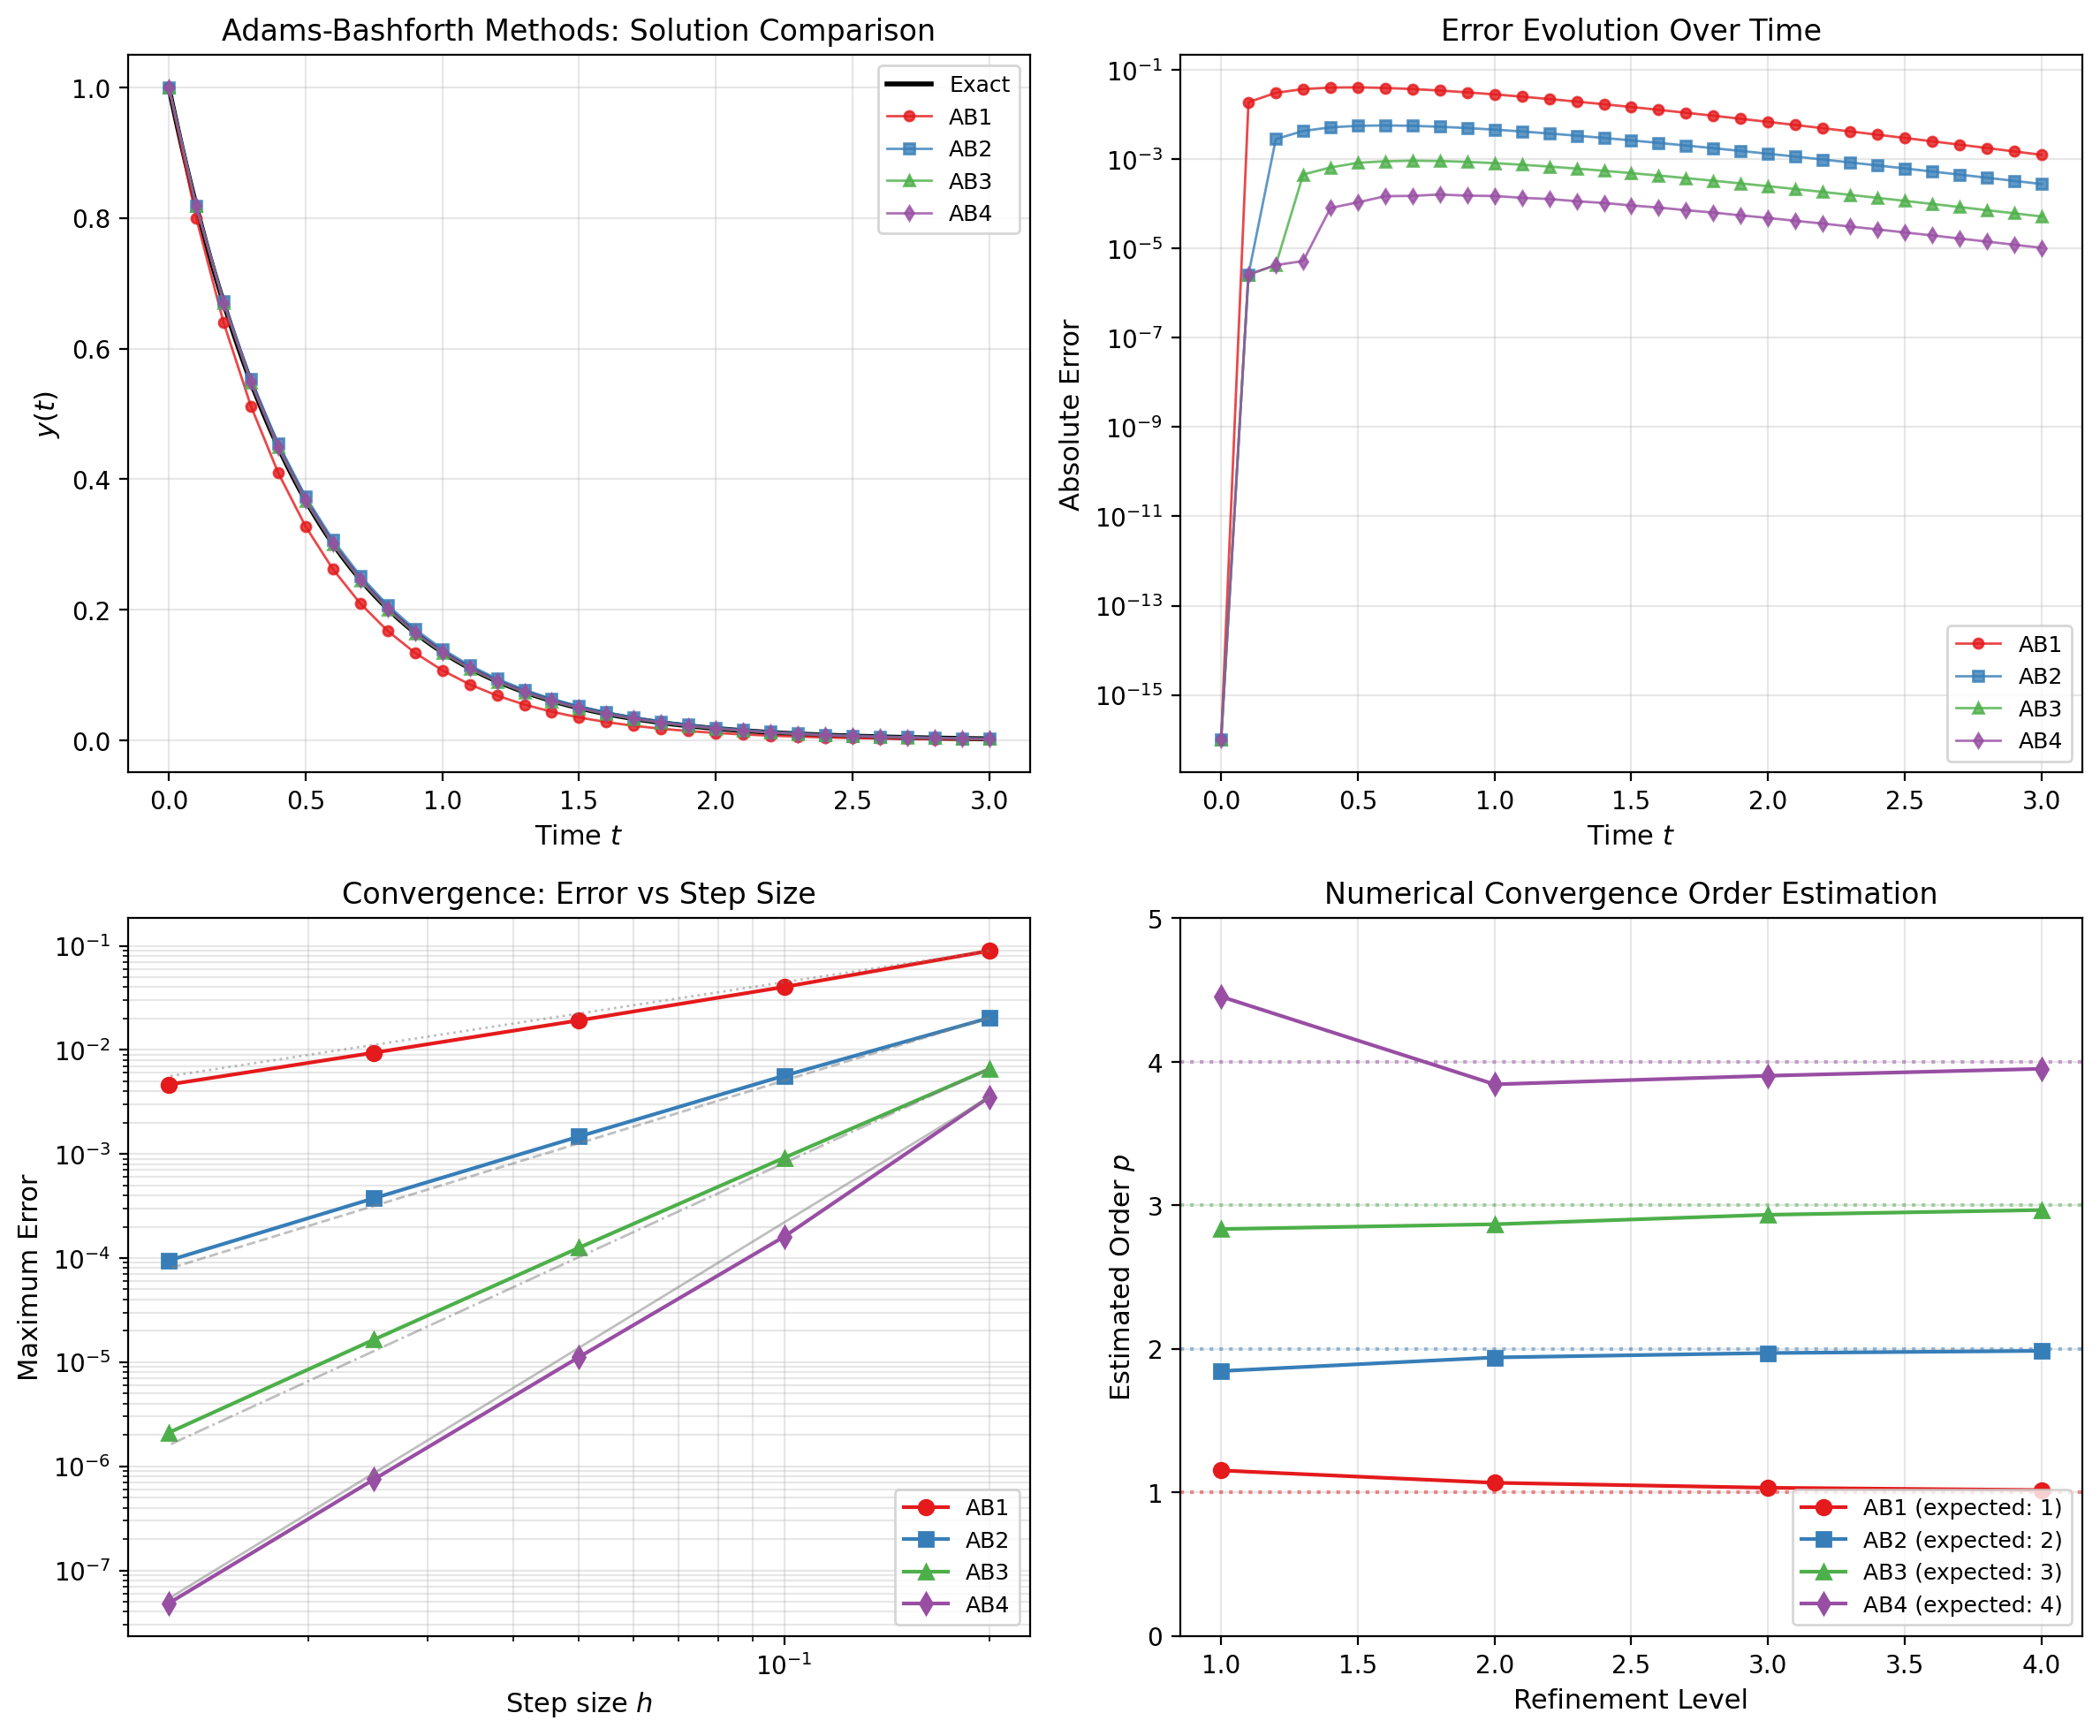

Figure saved to plot.png


In [3]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Solution comparison
ax1 = axes[0, 0]
ax1.plot(t_exact, y_exact, 'k-', linewidth=2, label='Exact')
colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3']
markers = ['o', 's', '^', 'd']
for i, order in enumerate([1, 2, 3, 4]):
    t, y = results[order]
    ax1.plot(t, y, f'{markers[i]}-', color=colors[i], 
             markersize=4, linewidth=1, alpha=0.8, label=f'AB{order}')
ax1.set_xlabel('Time $t$', fontsize=11)
ax1.set_ylabel('$y(t)$', fontsize=11)
ax1.set_title('Adams-Bashforth Methods: Solution Comparison', fontsize=12)
ax1.legend(loc='upper right', fontsize=9)
ax1.grid(True, alpha=0.3)

# Plot 2: Error over time
ax2 = axes[0, 1]
for i, order in enumerate([1, 2, 3, 4]):
    t, y = results[order]
    error = np.abs(y - exact_solution(t))
    ax2.semilogy(t, error + 1e-16, f'{markers[i]}-', color=colors[i], 
                 markersize=4, linewidth=1, alpha=0.8, label=f'AB{order}')
ax2.set_xlabel('Time $t$', fontsize=11)
ax2.set_ylabel('Absolute Error', fontsize=11)
ax2.set_title('Error Evolution Over Time', fontsize=12)
ax2.legend(loc='lower right', fontsize=9)
ax2.grid(True, alpha=0.3)

# Plot 3: Convergence study
ax3 = axes[1, 0]
step_sizes = [0.2, 0.1, 0.05, 0.025, 0.0125]
errors = {order: [] for order in [1, 2, 3, 4]}

for h_test in step_sizes:
    for order in [1, 2, 3, 4]:
        t, y = adams_bashforth(f_decay, t_span, y0, h_test, order=order)
        max_error = np.max(np.abs(y - exact_solution(t)))
        errors[order].append(max_error)

for i, order in enumerate([1, 2, 3, 4]):
    ax3.loglog(step_sizes, errors[order], f'{markers[i]}-', color=colors[i], 
               markersize=6, linewidth=1.5, label=f'AB{order}')

# Add reference slopes
h_ref = np.array([0.2, 0.0125])
for p, ls in [(1, ':'), (2, '--'), (3, '-.'), (4, '-')]:
    scale = errors[p][0] / h_ref[0]**p
    ax3.loglog(h_ref, scale * h_ref**p, ls, color='gray', alpha=0.5, linewidth=1)

ax3.set_xlabel('Step size $h$', fontsize=11)
ax3.set_ylabel('Maximum Error', fontsize=11)
ax3.set_title('Convergence: Error vs Step Size', fontsize=12)
ax3.legend(loc='lower right', fontsize=9)
ax3.grid(True, alpha=0.3, which='both')

# Plot 4: Estimated convergence orders
ax4 = axes[1, 1]
h_arr = np.array(step_sizes)
for i, order in enumerate([1, 2, 3, 4]):
    err_arr = np.array(errors[order])
    # Compute numerical order of convergence
    p_est = np.log(err_arr[:-1] / err_arr[1:]) / np.log(h_arr[:-1] / h_arr[1:])
    ax4.plot(range(1, len(p_est) + 1), p_est, f'{markers[i]}-', color=colors[i], 
             markersize=6, linewidth=1.5, label=f'AB{order} (expected: {order})')
    ax4.axhline(y=order, color=colors[i], linestyle=':', alpha=0.5)

ax4.set_xlabel('Refinement Level', fontsize=11)
ax4.set_ylabel('Estimated Order $p$', fontsize=11)
ax4.set_title('Numerical Convergence Order Estimation', fontsize=12)
ax4.legend(loc='lower right', fontsize=9)
ax4.grid(True, alpha=0.3)
ax4.set_ylim([0, 5])

plt.tight_layout()
plt.savefig('adams_bashforth_method_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("Figure saved to plot.png")

## Summary and Discussion

### Key Findings

1. **Convergence Order**: Each Adams-Bashforth method achieves its theoretical convergence order. AB1 is $O(h)$, AB2 is $O(h^2)$, AB3 is $O(h^3)$, and AB4 is $O(h^4)$.

2. **Efficiency**: Higher-order methods require fewer function evaluations per step compared to equivalent-order Runge-Kutta methods, making them computationally efficient for smooth problems.

3. **Bootstrap Requirement**: Multi-step methods need starting values from a single-step method (here RK4), which is a minor overhead.

### Advantages

- Only **one function evaluation per step** after initialization
- High accuracy for smooth solutions
- Easy to implement and extend to higher orders

### Limitations

- Smaller stability regions compared to implicit methods
- Not suitable for stiff equations without modification
- Requires uniform step sizes (adaptive variants exist but are more complex)

### Extensions

- **Adams-Moulton methods**: Implicit variants with larger stability regions
- **Predictor-corrector schemes**: Combine Adams-Bashforth (predictor) with Adams-Moulton (corrector)
- **Variable step-size methods**: Adapt $h$ based on local error estimates